# Implement and train a LSTM for sentiment analysis

(General Hint on Lab 1/2: Trust whatever you see from the training and report it on PDF. IDMB is far from ideal as it's more like a real-world dataset)

## Step 0: set up the environment

In [4]:
import functools
import sys
import numpy as np
import pandas as pd
import random
import re
import matplotlib.pyplot as plt
import tqdm
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

nltk.download('stopwords')

torch.backends.cudnn.benchmark = True

import os
os.makedirs("resources", exist_ok=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Hyperparameters. Do not directly touch this to mess up settings.

If you want to initalize new hyperparameter sets, use "new_hparams = HyperParams()" and change corresponding fields.

In [5]:
class HyperParams:
    def __init__(self):
        # Constance hyperparameters. They have been tested and don't need to be tuned.
        self.PAD_INDEX = 0
        self.UNK_INDEX = 1
        self.PAD_TOKEN = '<pad>'
        self.UNK_TOKEN = '<unk>'
        self.STOP_WORDS = set(stopwords.words('english'))
        self.MAX_LENGTH = 256
        self.BATCH_SIZE = 96
        self.EMBEDDING_DIM = 1
        self.HIDDEN_DIM = 100
        self.OUTPUT_DIM = 2
        self.N_LAYERS = 1
        self.DROPOUT_RATE = 0.0
        self.LR = 0.01
        self.N_EPOCHS = 5
        self.WD = 0
        self.OPTIM = "sgd"
        self.BIDIRECTIONAL = False
        self.SEED = 5

## Lab 1(a) Implement your own data loader function.  
First, you need to read the data from the dataset file on the local disk.
Then, split the dataset into three sets: train, validation and test by 7:1:2 ratio.
Finally return x_train, x_valid, x_test, y_train, y_valid, y_test where x represents reviews and y represent labels.  

In [7]:
#from google.colab import drive
#drive.mount('/content/drive')
#file_path = '/content/drive/MyDrive/Colab_Notebooks/ECE661/HW2'

In [18]:
def load_imdb(base_csv:str = './IMDBDataset.csv', google_drive = False):
    """
    Load the IMDB dataset
    :param base_csv: the path of the dataset file.
    :return: train, validation and test set.
    """
    # Add your code here.
    file_path = base_csv
    if google_drive:
      # if using gdrive for assignment
      file_path = '/content/drive/MyDrive/Colab_Notebooks/ECE661/HW3' + base_csv[1:]

    # read in data
    data = pd.read_csv(file_path)
    X = data['review']
    y = data['sentiment']

    x_train, x_valid_test, y_train, y_valid_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = True)
    x_valid, x_test, y_valid, y_test = train_test_split(x_valid_test, y_valid_test, test_size = 2/3, random_state = 42, shuffle = True)

    print(f'shape of train data is {x_train.shape}')
    print(f'shape of test data is {x_test.shape}')
    print(f'shape of valid data is {x_valid.shape}')
    return x_train.values, x_valid.values, x_test.values, y_train.values, y_valid.values, y_test.values

## Lab 1(b): Implement your function to build a vocabulary based on the training corpus.
You should first compute the frequency of all the words in the training corpus.
Use the given preprocess_string() function to process each word by "preprocess_string(word)".
Avoid the words that are in the STOP_WORDS.
Filter the words by their frequency (>=min_freq).
Generate a corpus variable which contains a list of words.  

In [19]:
def build_dict(lst:list):
  """Helper function to build a dictionary of words and their frequencies"""
  word_dict = {}
  for word in lst:
    if word not in word_dict:
      word_dict[word] = 1
    else:
      word_dict[word] = word_dict[word] + 1
  return word_dict

def build_vocab(x_train:list, min_freq: int=5, hparams=None) -> dict:
    """
    build a vocabulary based on the training corpus.
    :param x_train:  List. The training corpus. Each sample in the list is a string of text.
    :param min_freq: Int. The frequency threshold for selecting words.
    :return: dictionary {word:index}
    """
    # Add your code here. Your code should assign corpus with a list of words.

    remove_punc = str.maketrans('', '', '!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~')

    corpus = [sentence.lower() for sentence in x_train] #lowercase all words
    #corpus = [text.replace("<br /><br />", " ") for text in corpus] # remove all line breaks - should we be doing this?
    #corpus = [text.translate(remove_punc) for text in corpus] # remove all punctuation from the sentences
    corpus = [sentence.split() for sentence in corpus] # separate the words
    corpus = [word for sample in corpus for word in sample] # flatten the list
    corpus = [word for word in corpus if word not in hparams.STOP_WORDS] # remove stopwords
    corpus = build_dict(corpus)

    # sorting on the basis of most common words
    # corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:1000]
    corpus_ = [word for word, freq in corpus.items() if freq >= min_freq]
    # creating a dict
    vocab = {w:i+2 for i, w in enumerate(corpus_)}
    vocab[hparams.PAD_TOKEN] = hparams.PAD_INDEX
    vocab[hparams.UNK_TOKEN] = hparams.UNK_INDEX
    return vocab

## Lab 1(c): Implement your tokenize function.
You should leverage the given preprocess_string() function to process each word by "preprocess_string(word)".
For each word, find its index in the vocabulary.
Return a list of int that represents the indices of words in the example.

In [20]:
def tokenize(vocab: dict, example: str)-> list:
    """
    Tokenize the give example string into a list of token indices.
    :param vocab: dict, the vocabulary.
    :param example: a string of text.
    :return: a list of token indices.
    """
    # Your code here.
    lst = example.split()
    tokens = []
    params = HyperParams()
    for word in lst:
      if word not in vocab:
        tokens.append(vocab[params.UNK_TOKEN])
      else:
        tokens.append(vocab[word])
    return tokens

## Lab 1 (d): Implement the __getitem__ function. Given an index i, you should return the i-th review and label.
The review is originally a string. Please tokenize it into a sequence of token indices.
Use the max_length parameter to truncate the sequence so that it contains at most max_length tokens.
Convert the label string ('positive'/'negative') to a binary index. 'positive' is 1 and 'negative' is 0.
Return a dictionary containing three keys: 'ids', 'length', 'label' which represent the list of token ids, the length of the sequence, the binary label.

In [11]:
class IMDB(Dataset):
    def __init__(self, x, y, vocab, max_length=256) -> None:
        """
        :param x: list of reviews
        :param y: list of labels
        :param vocab: vocabulary dictionary {word:index}.
        :param max_length: the maximum sequence length.
        """
        self.x = x
        self.y = y
        self.vocab = vocab
        self.max_length = max_length

    def __getitem__(self, idx: int):
        """
        Return the tokenized review and label by the given index.
        :param idx: index of the sample.
        :return: a dictionary containing three keys: 'ids', 'length', 'label' which represent the list of token ids, the length of the sequence, the binary label.
        """
        # Add your code here.
        review = self.x[idx]
        label = self.y[idx]

        params = HyperParams()

        tokenized_sentence = tokenize(self.vocab, review)
        if len(tokenized_sentence) > params.MAX_LENGTH:
          tokenized_sentence = tokenized_sentence[:params.MAX_LENGTH] #truncating the sequence
        tokenized_label = 1 if label == 'positive' else 0

        return {"ids": tokenized_sentence, "length": len(tokenized_sentence), "label": tokenized_label}


    def __len__(self) -> int:
        return len(self.x)

def collate(batch, pad_index):
    batch_ids = [torch.LongTensor(i['ids']) for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_length = torch.Tensor([i['length'] for i in batch])
    batch_label = torch.LongTensor([i['label'] for i in batch])
    batch = {'ids': batch_ids, 'length': batch_length, 'label': batch_label}
    return batch

collate_fn = collate

## Lab 1 (e): Implement the LSTM model for sentiment analysis.
Q(a): Implement the initialization function.
Your task is to create the model by stacking several necessary layers including an embedding layer, a lstm cell, a linear layer, and a dropout layer.
You can call functions from Pytorch's nn library. For example, nn.Embedding, nn.LSTM, nn.Linear.<br>
Q(b): Implement the forward function.
    Decide where to apply dropout.
    The sequences in the batch have different lengths. Write/call a function to pad the sequences into the same length.
    Apply a fully-connected (fc) layer to the output of the LSTM layer.
    Return the output features which is of size [batch size, output dim].

In [72]:
def init_weights(m):
    if isinstance(m, nn.Embedding):
        nn.init.xavier_normal_(m.weight)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM) or isinstance(m, nn.GRU):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_dim: int,
        output_dim: int,
        n_layers: int,
        dropout_rate: float,
        pad_index: int,
        bidirectional: bool,
        **kwargs):
        """
        Create a LSTM model for classification.
        :param vocab_size: size of the vocabulary
        :param embedding_dim: dimension of embeddings
        :param hidden_dim: dimension of hidden features
        :param output_dim: dimension of the output layer which equals to the number of labels.
        :param n_layers: number of layers.
        :param dropout_rate: dropout rate.
        :param pad_index: index of the padding token.we
        """
        super().__init__()
        # Add your code here. Initializing each layer by the given arguments.
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_index) # is vocab size right here? is padding_idx right here?
        self.lstm_cell = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = bidirectional, batch_first = True) #do we implement dropout here? batch_first? true
        lstm_hidden_layer = hidden_dim * 2 if bidirectional else hidden_dim
        self.linear_layer = nn.Linear(lstm_hidden_layer, output_dim) # must change hidden size if bidirectional.
        self.dropout = nn.Dropout(p = dropout_rate) # is this necessary?
        self.bidirectional = bidirectional
        self.num_layers = n_layers
        self.hidden_dim = hidden_dim

        # Weight initialization. DO NOT CHANGE!
        if "weight_init_fn" not in kwargs:
            self.apply(init_weights)
        else:
            self.apply(kwargs["weight_init_fn"])


    def forward(self, ids:torch.Tensor, length:torch.Tensor):
        """
        Feed the given token ids to the model.
        :param ids: [batch size, seq len] batch of token ids.
        :param length: [batch size] batch of length of the token ids. 
        :return: prediction of size [batch size, output dim].
        """
        # Add your code here.

        # padding ids
        #input = pad_sequence(ids, batch_first=True)
        input = self.embedding_layer(ids)
        input = pack_padded_sequence(input, length, batch_first = True, enforce_sorted = False)
        output, (hidden_layer, c_n) = self.lstm_cell(input)

        # concatenate hidden_layer if bidirectional
        if self.bidirectional:
            hidden_layer = hidden_layer.view(self.num_layers, 2, len(length), self.hidden_dim)
            hidden_layer = hidden_layer.permute(0, 2, 3, 1).reshape(self.num_layers, len(length), self.hidden_dim * 2)

        prediction = self.dropout(hidden_layer)
        prediction = self.linear_layer(prediction)
        return prediction[0]

In [35]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train(dataloader, model, criterion, optimizer, scheduler, device):
    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(dataloader, desc='training...', file=sys.stdout):
        ids = batch['ids'].to(device)
        length = batch['length']
        label = batch['label'].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
        scheduler.step()

    return epoch_losses, epoch_accs

def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)
            length = batch['length']
            label = batch['label'].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

def predict_sentiment(text, model, vocab, device):
    tokens = tokenize(vocab, text)
    ids = [vocab[t] if t in vocab else UNK_INDEX for t in tokens]
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

### Lab 1 (g) Implement GRU.

In [70]:
class GRU(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_dim: int,
        output_dim: int,
        n_layers: int,
        dropout_rate: float,
        pad_index: int,
        bidirectional: bool,
        **kwargs):
        """
        Create a LSTM model for classification.
        :param vocab_size: size of the vocabulary
        :param embedding_dim: dimension of embeddings
        :param hidden_dim: dimension of hidden features
        :param output_dim: dimension of the output layer which equals to the number of labels.
        :param n_layers: number of layers.
        :param dropout_rate: dropout rate.
        :param pad_index: index of the padding token.we
        """
        super().__init__()
        # Add your code here. Initializing each layer by the given arguments.
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_index) # is vocab size right here? is padding_idx right here?
        self.gru_cell = nn.GRU(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = bidirectional, batch_first = True) #do we implement dropout here? batch_first? true
        gru_hidden_layer = hidden_dim * 2 if bidirectional else hidden_dim
        self.linear_layer = nn.Linear(gru_hidden_layer, output_dim) # must change hidden size if bidirectional.
        self.dropout = nn.Dropout(p = dropout_rate) # is this necessary?
        self.bidirectional = bidirectional
        self.num_layers = n_layers
        self.hidden_dim = hidden_dim

        # Weight initialization. DO NOT CHANGE!
        if "weight_init_fn" not in kwargs:
            self.apply(init_weights)
        else:
            self.apply(kwargs["weight_init_fn"])


    def forward(self, ids:torch.Tensor, length:torch.Tensor):
        """
        Feed the given token ids to the model.
        :param ids: [batch size, seq len] batch of token ids.
        :param length: [batch size] batch of length of the token ids. # WHAT IS THIS USED FOR??
        :return: prediction of size [batch size, output dim].
        """
        # Add your code here.

        # padding ids
        #input = pad_sequence(ids, batch_first=True)
        input = self.embedding_layer(ids)
        input = pack_padded_sequence(input, length, batch_first = True, enforce_sorted = False)
        output, hidden_layer = self.gru_cell(input)
        if self.bidirectional:
            hidden_layer = hidden_layer.view(self.num_layers, 2, len(length), self.hidden_dim)
            hidden_layer = hidden_layer.permute(0, 2, 3, 1).reshape(self.num_layers, len(length), self.hidden_dim * 2)
        prediction = self.dropout(hidden_layer)
        prediction = self.linear_layer(prediction)

        return prediction[0]

### Learning rate warmup. DO NOT TOUCH!

In [15]:
class ConstantWithWarmup(torch.optim.lr_scheduler._LRScheduler):
    def __init__(
        self,
        optimizer,
        num_warmup_steps: int,
    ):
        self.num_warmup_steps = num_warmup_steps
        super().__init__(optimizer)

    def get_lr(self):
        if self._step_count <= self.num_warmup_steps:
            # warmup
            scale = 1.0 - (self.num_warmup_steps - self._step_count) / self.num_warmup_steps
            lr = [base_lr * scale for base_lr in self.base_lrs]
            self.last_lr = lr
        else:
            lr = self.base_lrs
        return lr

### Implement the training / validation iteration here.

In [16]:
def train_and_test_model_with_hparams(hparams, model_type="lstm", **kwargs):
    # Seeding. DO NOT TOUCH! DO NOT TOUCH hparams.SEED!
    # Set the random seeds.
    torch.manual_seed(hparams.SEED)
    random.seed(hparams.SEED)
    np.random.seed(hparams.SEED)

    x_train, x_valid, x_test, y_train, y_valid, y_test = load_imdb()
    vocab = build_vocab(x_train, hparams=hparams)
    vocab_size = len(vocab)
    print(f'Length of vocabulary is {vocab_size}')

    train_data = IMDB(x_train, y_train, vocab, hparams.MAX_LENGTH)
    valid_data = IMDB(x_valid, y_valid, vocab, hparams.MAX_LENGTH)
    test_data = IMDB(x_test, y_test, vocab, hparams.MAX_LENGTH)

    collate = functools.partial(collate_fn, pad_index=hparams.PAD_INDEX)

    train_dataloader = torch.utils.data.DataLoader(
        train_data, batch_size=hparams.BATCH_SIZE, collate_fn=collate, shuffle=True)
    valid_dataloader = torch.utils.data.DataLoader(
        valid_data, batch_size=hparams.BATCH_SIZE, collate_fn=collate)
    test_dataloader = torch.utils.data.DataLoader(
        test_data, batch_size=hparams.BATCH_SIZE, collate_fn=collate)

    model_type = 'lstm'

    # Model
    if "override_models_with_gru" in kwargs and kwargs["override_models_with_gru"]:
        model = GRU(
            vocab_size,
            hparams.EMBEDDING_DIM,
            hparams.HIDDEN_DIM,
            hparams.OUTPUT_DIM,
            hparams.N_LAYERS,
            hparams.DROPOUT_RATE,
            hparams.PAD_INDEX,
            hparams.BIDIRECTIONAL,
            **kwargs)
        model_type = 'gru'
        print("Model Type: ", model_type)
    else:
        model = LSTM(
            vocab_size,
            hparams.EMBEDDING_DIM,
            hparams.HIDDEN_DIM,
            hparams.OUTPUT_DIM,
            hparams.N_LAYERS,
            hparams.DROPOUT_RATE,
            hparams.PAD_INDEX,
            hparams.BIDIRECTIONAL,
            **kwargs)
        print("Model Type: ", model_type)
    num_params = count_parameters(model)
    print(f'The model has {num_params:,} trainable parameters')


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Optimization. Lab 2 (a)(b) should choose one of them.
    # DO NOT TOUCH optimizer-specific hyperparameters! (e.g., eps, momentum)
    # DO NOT change optimizer implementations!
    if hparams.OPTIM == "sgd":
        optimizer = optim.SGD(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, momentum=.9)
    elif hparams.OPTIM == "adagrad":
        optimizer = optim.Adagrad(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, eps=1e-6)
    elif hparams.OPTIM == "adam":
        optimizer = optim.Adam(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, eps=1e-6)
    elif hparams.OPTIM == "rmsprop":
        optimizer = optim.RMSprop(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, eps=1e-6, momentum=.9)
    else:
        raise NotImplementedError("Optimizer not implemented!")

    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)

    # Start training
    best_valid_loss = float('inf')
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []

    # Warmup Scheduler. DO NOT TOUCH!
    WARMUP_STEPS = 200
    lr_scheduler = ConstantWithWarmup(optimizer, WARMUP_STEPS)

    for epoch in range(hparams.N_EPOCHS):

        # Your code: implement the training process and save the best model.

        train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, lr_scheduler, device)
        valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)

        epoch_train_loss = np.mean(train_loss)
        epoch_train_acc = np.mean(train_acc)
        epoch_valid_loss = np.mean(valid_loss)
        epoch_valid_acc = np.mean(valid_acc)

        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        valid_losses.append(epoch_valid_loss)
        valid_accs.append(epoch_valid_acc)

        # Save the model that achieves the smallest validation loss.
        if epoch_valid_loss < best_valid_loss:
            # Your code: save the best model somewhere (no need to submit it to Sakai)
            best_valid_loss = epoch_valid_loss
            if not os.path.exists('./saved_models'):
              os.makedirs('./saved_models')
            print("Saving ...")
            state = {'state_dict': model.state_dict(),
                'epoch': epoch}
            torch.save(state, os.path.join('./saved_models', f'best_{model_type}.pth'))

        print(f'epoch: {epoch+1}')
        print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
        print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')


    # Your Code: Load the best model's weights.
    if "override_models_with_gru" in kwargs and kwargs["override_models_with_gru"]:
        model = GRU(
            vocab_size,
            hparams.EMBEDDING_DIM,
            hparams.HIDDEN_DIM,
            hparams.OUTPUT_DIM,
            hparams.N_LAYERS,
            hparams.DROPOUT_RATE,
            hparams.PAD_INDEX,
            hparams.BIDIRECTIONAL,
            **kwargs)
    else:
        model = LSTM(
            vocab_size,
            hparams.EMBEDDING_DIM,
            hparams.HIDDEN_DIM,
            hparams.OUTPUT_DIM,
            hparams.N_LAYERS,
            hparams.DROPOUT_RATE,
            hparams.PAD_INDEX,
            hparams.BIDIRECTIONAL,
            **kwargs)
    state_dict = torch.load(f'./saved_models/best_{model_type}.pth') # change the path to your own checkpoint file
    model.load_state_dict(state_dict['state_dict'])
    model.to(device)

    # Your Code: evaluate test loss on testing dataset (NOT Validation)
    test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

    epoch_test_loss = np.mean(test_loss)
    epoch_test_acc = np.mean(test_acc)
    print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')

    # Free memory for later usage.
    del model
    torch.cuda.empty_cache()
    return {
        'num_params': num_params,
        "test_loss": epoch_test_loss,
        "test_acc": epoch_test_acc,
        "train_losses": train_losses,
        "train_accs": train_accs,
        "valid_losses": valid_losses,
        "valid_accs": valid_accs
    }

### Lab 1 (f): Train model with original hyperparameters, for LSTM.

Train the model with default hyperparameter settings.

In [ ]:
org_hyperparams = HyperParams()
lstm_results = train_and_test_model_with_hparams(org_hyperparams, "lstm_1layer_base_sgd_e32_h100")

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56492
Model Type:  lstm
The model has 97,894 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 23.67it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.504
valid_loss: 0.693, valid_acc: 0.512
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 17.66it/s]
epoch: 2
train_loss: 0.693, train_acc: 0.500
valid_loss: 0.693, valid_acc: 0.488
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 23.49it/s]
epoch: 3
train_loss: 0.693, train_acc: 0.506
valid_loss: 0.694, valid_acc: 0.488
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 22.33it/s]
epoch: 4
train_loss: 0.693, train_acc: 0.502
valid_loss: 0.693, valid_acc: 0.512
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 19.70it/s]
epoch: 5
train_loss: 0.693, train_acc: 0.502
valid_loss: 0.693, valid_acc: 0.512
evaluating...: 100%|██████████| 105/105 [00:04<00:00, 23.27it/s]
test_loss: 0.693, te

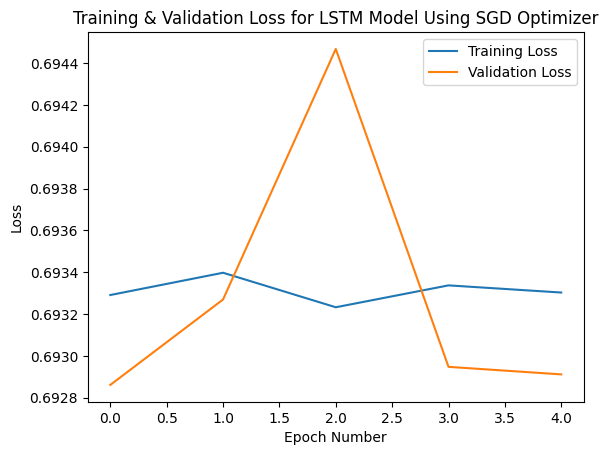

In [ ]:
plt.plot(lstm_results['train_losses'], label = 'Training Loss')
plt.plot(lstm_results['valid_losses'], label = 'Validation Loss')
plt.title("Training & Validation Loss for LSTM Model Using SGD Optimizer")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Lag 1 (h) Train GRU with vanilla hyperparameters.

In [ ]:
org_hyperparams = HyperParams()
results_gru = train_and_test_model_with_hparams(org_hyperparams, "gru_1layer_base_sgd_e32_h100", override_models_with_gru=True)

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56492
Model Type:  gru
The model has 87,594 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 24.93it/s]
Saving ...
epoch: 1
train_loss: 0.694, train_acc: 0.502
valid_loss: 0.693, valid_acc: 0.488
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 23.87it/s]
Saving ...
epoch: 2
train_loss: 0.694, train_acc: 0.498
valid_loss: 0.693, valid_acc: 0.488
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 15.83it/s]
epoch: 3
train_loss: 0.694, train_acc: 0.497
valid_loss: 0.694, valid_acc: 0.488
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 24.51it/s]
epoch: 4
train_loss: 0.694, train_acc: 0.500
valid_loss: 0.694, valid_acc: 0.488
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 25.13it/s]
epoch: 5
train_loss: 0.694, train_acc: 0.499
valid_loss: 0.694, valid_acc: 0.488
evaluating...: 100%|██████████| 105/105 [00:04<00:00, 24.03it/s]
test_loss:

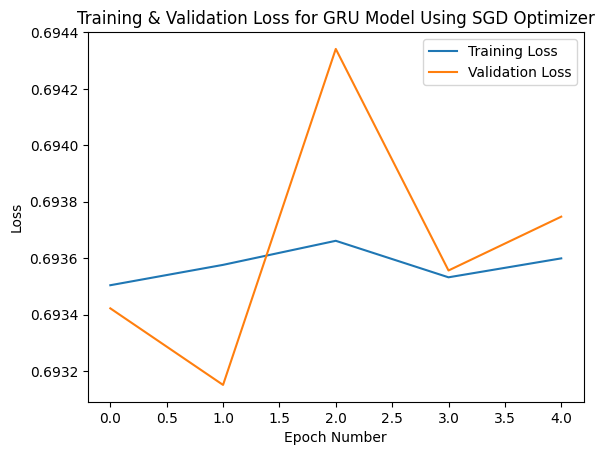

In [ ]:
plt.plot(results_gru['train_losses'], label = 'Training Loss')
plt.plot(results_gru['valid_losses'], label = 'Validation Loss')
plt.title("Training & Validation Loss for GRU Model Using SGD Optimizer")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Lab 2 (a) Study of LSTM Optimizers. Hint: For adaptive optimizers, we recommend using a learning rate of 0.001 (instead of 0.01).

In [ ]:
optimizers = ['sgd', 'adagrad', 'adam', 'rmsprop']
all_lstm_results = []

# training
for optimizer in optimizers:
  params = HyperParams()
  params.OPTIM = optimizer
  if optimizer != 'sgd':
    params.LR = 0.001
  model_results = train_and_test_model_with_hparams(params)
  all_lstm_results.append({optimizer: model_results})

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56492
Model Type:  lstm
The model has 97,894 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 16.34it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.504
valid_loss: 0.693, valid_acc: 0.512
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 17.59it/s]
epoch: 2
train_loss: 0.693, train_acc: 0.500
valid_loss: 0.693, valid_acc: 0.488
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 14.48it/s]
epoch: 3
train_loss: 0.693, train_acc: 0.506
valid_loss: 0.694, valid_acc: 0.488
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 19.19it/s]
epoch: 4
train_loss: 0.693, train_acc: 0.502
valid_loss: 0.693, valid_acc: 0.512
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 22.80it/s]
epoch: 5
train_loss: 0.693, train_acc: 0.502
valid_loss: 0.693, valid_acc: 0.512
evaluating...: 100%|██████████| 105/105 [00:06<00:00, 16.44it/s]
test_loss: 0.693, te

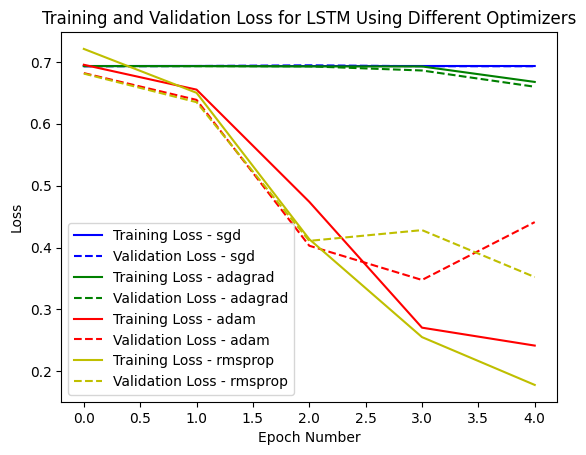

In [ ]:
# plot results
colors = ['b', 'g', 'r', 'y', 'c']
for i in range(len(all_lstm_results)):
  result = all_lstm_results[i]
  color = colors[i]
  label = list(result.keys())[0]
  plt.plot(result[label]['train_losses'], label = f'Training Loss - {label}', color = color)
  plt.plot(result[label]['valid_losses'], label = f'Validation Loss - {label}', linestyle='dashed', color = color)

plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.title("Training and Validation Loss for LSTM Using Different Optimizers")
plt.legend()
plt.show()

### Lab 2 (b): Study of GRU Optimizers. Hint: For adaptive optimizers, we recommend using a learning rate of 0.001 (instead of 0.01).

In [ ]:
optimizers = ['sgd', 'adagrad', 'adam', 'rmsprop']
all_gru_results = []

# training
for optimizer in optimizers:
  params = HyperParams()
  params.OPTIM = optimizer
  if optimizer != 'sgd':
    params.LR = 0.001
  model_results = train_and_test_model_with_hparams(params, "gru_1layer_base_sgd_e32_h100", override_models_with_gru=True)
  all_gru_results.append({optimizer: model_results})

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56492
Model Type:  gru
The model has 87,594 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 18.67it/s]
Saving ...
epoch: 1
train_loss: 0.694, train_acc: 0.502
valid_loss: 0.693, valid_acc: 0.488
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 24.69it/s]
Saving ...
epoch: 2
train_loss: 0.694, train_acc: 0.498
valid_loss: 0.693, valid_acc: 0.488
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 23.89it/s]
epoch: 3
train_loss: 0.694, train_acc: 0.497
valid_loss: 0.694, valid_acc: 0.488
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 21.81it/s]
epoch: 4
train_loss: 0.694, train_acc: 0.500
valid_loss: 0.694, valid_acc: 0.488
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 18.35it/s]
epoch: 5
train_loss: 0.694, train_acc: 0.499
valid_loss: 0.694, valid_acc: 0.488
evaluating...: 100%|██████████| 105/105 [00:04<00:00, 21.20it/s]
test_loss:

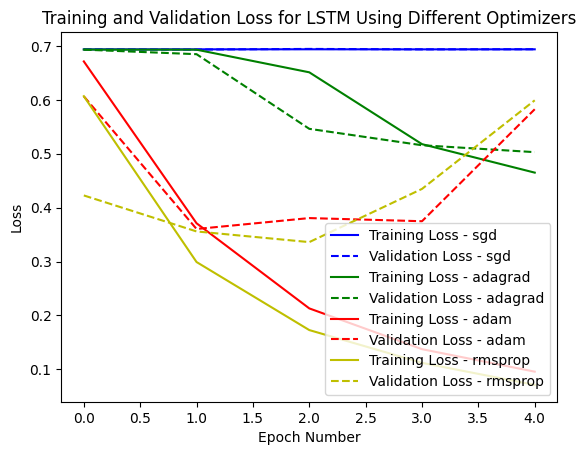

In [ ]:
# plot results
colors = ['b', 'g', 'r', 'y', 'c']
for i in range(len(all_gru_results)):
  result = all_gru_results[i]
  color = colors[i]
  label = list(result.keys())[0]
  plt.plot(result[label]['train_losses'], label = f'Training Loss - {label}', color = color)
  plt.plot(result[label]['valid_losses'], label = f'Validation Loss - {label}', linestyle='dashed', color = color)

plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.title("Training and Validation Loss for GRU Using Different Optimizers")
plt.legend()
plt.show()

### Lab 2 (c) Deeper LSTMs

In [16]:
optimizer = 'rmsprop' # we achieved the best results with rmsprop so we'll be using that for subsequent layers
all_lstm_test_accuracies = []
num_layers = [1, 2, 3, 4]
colors = ['b', 'g', 'r', 'y']

# training
for num_layer in num_layers:
  params = HyperParams()
  params.OPTIM = optimizer
  params.N_LAYERS = num_layer
  params.LR = 0.001
  model_results = train_and_test_model_with_hparams(params)
  all_lstm_test_accuracies.append({num_layer: model_results})

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56492
Model Type:  lstm
The model has 97,894 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 25.76it/s]
Saving ...
epoch: 1
train_loss: 0.725, train_acc: 0.511
valid_loss: 0.698, valid_acc: 0.497
evaluating...: 100%|██████████| 53/53 [00:04<00:00, 11.99it/s]
Saving ...
epoch: 2
train_loss: 0.669, train_acc: 0.569
valid_loss: 0.628, valid_acc: 0.635
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 23.36it/s]
Saving ...
epoch: 3
train_loss: 0.468, train_acc: 0.770
valid_loss: 0.493, valid_acc: 0.792
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 25.14it/s]
Saving ...
epoch: 4
train_loss: 0.268, train_acc: 0.893
valid_loss: 0.368, valid_acc: 0.844
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 25.86it/s]
epoch: 5
train_loss: 0.182, train_acc: 0.932
valid_loss: 0.417, valid_acc: 0.838
evaluating...: 100%|██████████| 105/105 [00:05<00:00

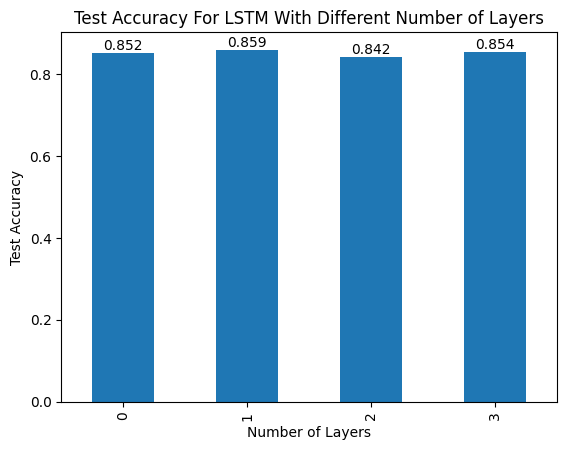

In [41]:
accuracies = pd.Series([all_lstm_test_accuracies[i][i + 1]['test_acc'] for i in range(len(all_lstm_test_accuracies))])

# Make some labels.
labels = [f"{accuracies[i]}" for i in range(len(accuracies))]

ax = accuracies.plot(kind='bar')
ax.set_title('Test Accuracy For LSTM With Different Number of Layers')
ax.set_xlabel('Number of Layers')
ax.set_ylabel('Test Accuracy')
ax.set_xticklabels([i + 1 for i in range(len(accuracies))])


for rect, label in zip(ax.patches, labels):
    height = rect.get_height()
    label = str(round(float(label), 3))
    plt.text(
        rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
    )

plt.show()

### Lab 2 (d) Wider LSTMs

In [43]:
optimizer = 'rmsprop' # we achieved the best results with rmsprop so we'll be using that for subsequent layers
hidden_units = [50, 100, 150, 200, 250, 300]
all_lstm_test_accuracies_wide = []

# training
for num_hidden_units in hidden_units:
  params = HyperParams()
  params.OPTIM = optimizer
  params.HIDDEN_DIM = num_hidden_units
  params.LR = 0.001
  model_results = train_and_test_model_with_hparams(params)
  all_lstm_test_accuracies_wide.append({num_hidden_units: model_results})

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56492
Model Type:  lstm
The model has 67,194 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 20.29it/s]
Saving ...
epoch: 1
train_loss: 0.719, train_acc: 0.523
valid_loss: 0.673, valid_acc: 0.564
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 24.80it/s]
Saving ...
epoch: 2
train_loss: 0.528, train_acc: 0.732
valid_loss: 0.375, valid_acc: 0.844
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 19.13it/s]
epoch: 3
train_loss: 0.322, train_acc: 0.866
valid_loss: 0.458, valid_acc: 0.818
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 16.69it/s]
epoch: 4
train_loss: 0.209, train_acc: 0.922
valid_loss: 0.401, valid_acc: 0.845
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 25.86it/s]
epoch: 5
train_loss: 0.145, train_acc: 0.949
valid_loss: 0.440, valid_acc: 0.839
evaluating...: 100%|██████████| 105/105 [00:04<00:00, 24.18it/s]
test_loss

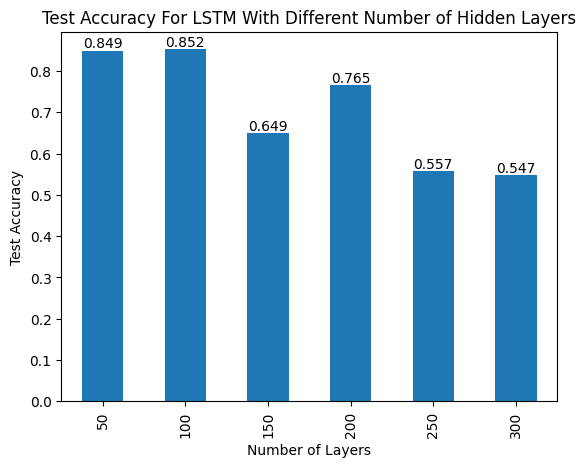

In [44]:
accuracies = pd.Series([all_lstm_test_accuracies_wide[i][hidden_units[i]]['test_acc'] for i in range(len(all_lstm_test_accuracies_wide))])

# Make some labels.
labels = [f"{accuracies[i]}" for i in range(len(accuracies))]

ax = accuracies.plot(kind='bar')
ax.set_title('Test Accuracy For LSTM With Different Number of Hidden Layers')
ax.set_xlabel('Number of Layers')
ax.set_ylabel('Test Accuracy')
ax.set_xticklabels(hidden_units)


for rect, label in zip(ax.patches, labels):
    height = rect.get_height()
    label = str(round(float(label), 3))
    plt.text(
        rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
    )

plt.show()

### Lab 2 (e) Larger Embedding Table

In [46]:
optimizer = 'rmsprop' # we achieved the best results with rmsprop so we'll be using that for subsequent layers
embedding_sizes = [16, 32, 64, 128, 256]
all_lstm_test_accuracies_embedding = []

# training
for embedding_size in embedding_sizes:
  params = HyperParams()
  params.OPTIM = optimizer
  params.EMBEDDING_DIM = embedding_size
  params.LR = 0.001
  model_results = train_and_test_model_with_hparams(params)
  all_lstm_test_accuracies_embedding.append({embedding_size: model_results})

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56492
Model Type:  lstm
The model has 951,274 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 19.90it/s]
Saving ...
epoch: 1
train_loss: 0.675, train_acc: 0.584
valid_loss: 0.655, valid_acc: 0.591
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 24.25it/s]
Saving ...
epoch: 2
train_loss: 0.381, train_acc: 0.828
valid_loss: 0.328, valid_acc: 0.853
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 24.82it/s]
epoch: 3
train_loss: 0.205, train_acc: 0.920
valid_loss: 0.333, valid_acc: 0.858
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 24.75it/s]
epoch: 4
train_loss: 0.116, train_acc: 0.959
valid_loss: 0.408, valid_acc: 0.851
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 13.37it/s]
epoch: 5
train_loss: 0.062, train_acc: 0.980
valid_loss: 0.559, valid_acc: 0.845
evaluating...: 100%|██████████| 105/105 [00:04<00:00, 23.21it/s]
test_los

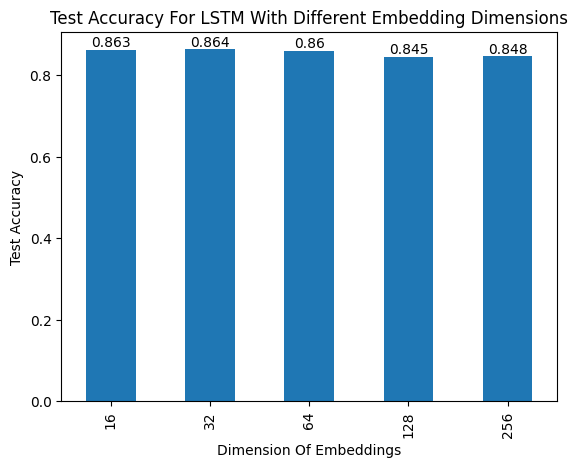

In [47]:
accuracies = pd.Series([all_lstm_test_accuracies_embedding[i][embedding_sizes[i]]['test_acc'] for i in range(len(all_lstm_test_accuracies_embedding))])

# Make some labels.
labels = [f"{accuracies[i]}" for i in range(len(accuracies))]

ax = accuracies.plot(kind='bar')
ax.set_title('Test Accuracy For LSTM With Different Embedding Dimensions')
ax.set_xlabel('Dimension Of Embeddings')
ax.set_ylabel('Test Accuracy')
ax.set_xticklabels(embedding_sizes)


for rect, label in zip(ax.patches, labels):
    height = rect.get_height()
    label = str(round(float(label), 3))
    plt.text(
        rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
    )

plt.show()

### Lab 2(f) Compound scaling of embedding_dim, hidden_dim, layers

In [21]:
num_layers = [1, 2, 3, 4]
hidden_units = [50, 100]
embedding_sizes = [16, 32]
learning_rates = [0.001, 0.0001]

counter = 0
params_results = []
combined_results = []

for num_layer in num_layers:
  for hidden_unit in hidden_units:
    for embedding_size in embedding_sizes:
      for learning_rate in learning_rates:
        params = HyperParams()
        params.OPTIM = 'rmsprop'
        params.EMBEDDING_DIM = embedding_size
        params.LR = learning_rate
        params.HIDDEN_DIM = hidden_unit
        params.N_LAYERS = num_layer

        model_results = train_and_test_model_with_hparams(params)
        combined_results.append({counter: model_results})
        params_results.append({counter: {'num_layer': num_layer, 'hidden_unit': hidden_unit, 'embedding_size': embedding_size, 'learning_rate': learning_rate}})
        counter += 1

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56492
Model Type:  lstm
The model has 917,574 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 22.76it/s]
Saving ...
epoch: 1
train_loss: 0.612, train_acc: 0.663
valid_loss: 0.552, valid_acc: 0.711
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 22.11it/s]
Saving ...
epoch: 2
train_loss: 0.415, train_acc: 0.817
valid_loss: 0.440, valid_acc: 0.781
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 23.35it/s]
Saving ...
epoch: 3
train_loss: 0.247, train_acc: 0.902
valid_loss: 0.392, valid_acc: 0.854
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 23.29it/s]
epoch: 4
train_loss: 0.150, train_acc: 0.945
valid_loss: 0.400, valid_acc: 0.859
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 23.16it/s]
epoch: 5
train_loss: 0.080, train_acc: 0.973
valid_loss: 0.538, valid_acc: 0.838
evaluating...: 100%|██████████| 105/105 [00:04<00:00, 22.91it/

In [23]:
# figure out how to plot the above
accuracies = pd.Series([combined_results[i][i]['test_acc'] for i in range(len(combined_results))])

# find the index of max accuracy:
print("Max Test Accuracy: ", accuracies[accuracies.idxmax()])
print("Hyperparameter values: ", params_results[accuracies.idxmax()])

Max Test Accuracy:  0.8717262080737522
Hyperparameter values:  {30: {'num_layer': 4, 'hidden_unit': 100, 'embedding_size': 32, 'learning_rate': 0.001}}


### Lab 2 (g) Bi-Directional LSTM, using best architecture from (f)

In [51]:
# save the best results
pd.Series(params_results).to_csv("best_params.csv")
pd.Series(accuracies).to_csv("Test_Accuracy_Results_2f.csv")

In [73]:
optimal_params = HyperParams()
best_params = params_results[accuracies.idxmax()][accuracies.idxmax()]
optimal_params.OPTIM = 'rmsprop'
optimal_params.EMBEDDING_DIM = best_params['embedding_size']
optimal_params.LR = best_params['learning_rate']
optimal_params.HIDDEN_DIM = best_params['hidden_unit']
optimal_params.N_LAYERS = best_params['num_layer']
optimal_params.BIDIRECTIONAL = True
model_results = train_and_test_model_with_hparams(optimal_params)

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56492
Model Type:  lstm
The model has 2,640,146 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 13.91it/s]
Saving ...
epoch: 1
train_loss: 0.607, train_acc: 0.662
valid_loss: 0.546, valid_acc: 0.782
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 13.90it/s]
Saving ...
epoch: 2
train_loss: 0.304, train_acc: 0.873
valid_loss: 0.335, valid_acc: 0.858
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 13.88it/s]
epoch: 3
train_loss: 0.154, train_acc: 0.942
valid_loss: 0.380, valid_acc: 0.850
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 13.96it/s]
epoch: 4
train_loss: 0.063, train_acc: 0.979
valid_loss: 0.562, valid_acc: 0.841
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 13.91it/s]
epoch: 5
train_loss: 0.022, train_acc: 0.993
valid_loss: 0.694, valid_acc: 0.837
evaluating...: 100%|██████████| 105/105 [00:07<00:00, 13.81it/s]
test_l

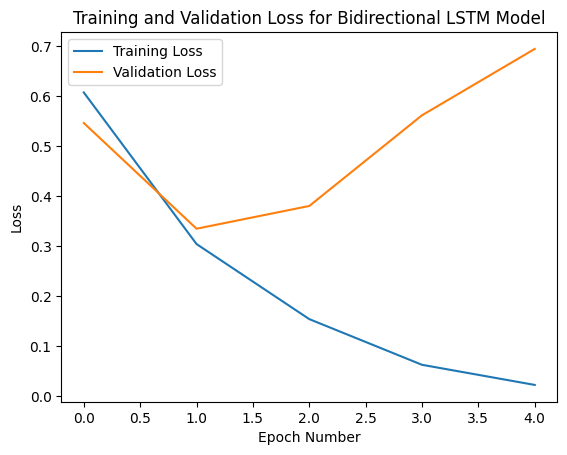

Test Accuracy For Best LSTM Model (Non-Bidirectional):  0.8717262080737522
Test Accuracy For Best LSTM Model (Bidirectional):  0.8682539860407511


In [77]:
plt.plot(model_results['train_losses'], label = f'Training Loss')
plt.plot(model_results['valid_losses'], label = f'Validation Loss')

plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.title("Training and Validation Loss for Bidirectional LSTM Model")
plt.legend()
plt.show()

print("Test Accuracy For Best LSTM Model (Non-Bidirectional): ", accuracies[accuracies.idxmax()])
print("Test Accuracy For Best LSTM Model (Bidirectional): ", model_results['test_acc'])